In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## TODO:

1. Data: 
    - **done** create script to combine all congresses
    - **done** create a party and chamber lists for addtional support
    - **done** create congress number list

2. Train/Val/Test split:
    -  **done** Put into a separate module
    -  **done** Add an option to select a party or chapter
    - **memory error** Split train/val/test by congress to avoid time bias
    - Play with hyperparameters:
        - word_count
        - random_splits: allocate more to training?
        - increase balance ratio?

3. EDA:
    - Targets by party: should we run gender/ethnicity on Ds only?

4. Vectorization:
    - Tune hyper parameters:
        - ngram_range: 1, 3
        - change vocabulary size
    - Add outputs:
        - **done** stop words
        - **done** lowest scoring words
        - **done** top n 5 by congress

5. Ngram model:
    - Tune hyper parameters:
        - use GridSearch?
        - activation function
        - learning rate
        - batch size
        - layers
        - units
        - dropout rate
        - any other regularization (there is significant overfit)
    - Run model:
        - for each congress
        - add one congress at a time
           - hypothesis: is accuracy improving due to more data or more diversity?
        - run only for Ds?
    - Outputs:
        - **done** how to output predicted probablity?
    - Model validation:
        - **done** build a separate function so it can be used with different models:
            - **done** input: predicted probability; actual labels; data (val or test?)
        - **done** chart distribution of the predicted probability 
        - **done** bin predicted probabilities into:
            - **done** 0:0.4, 0.4:0.6, 0.6:1?
            - **done** accuracy in each bin
            - **done** crosstab them with various demos (party, chamber, age, year)
            - **done** get 1,2,3-grams for each bin
        - **done** output examples of speeches with scores close to 1 and close to 0 that are mispredicted vs predicted correctly
        - Accuracy/loss by congress
        - Accuracy/loss as congresses added
            - save them and plot them

### Long term:

1. classificaiton models:
    - ngram vanilla NN
    - CNN
    - sentence embeddings
    - some other models
    - does it help to combine the results ensemble? if they make different mistakes, it should.
2. Create a topics model:
    - on raw data before classification
    - on groups based on predicted probability bings:
       - can we explain classification by topics that they bring up?
       - or is it just based on language used? here we would check 1,2,3-ngrams
3. Age:
    - aging congress: how does it affect topics that people bring up?
4. Speaker-level analysis:
    - cluster speakers (k-means?) by their average predicted scores in classification models?
        - for example, a white male that is closer to women by the way they use speech? are they liberals?

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [37]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

## Load the data

In [4]:
pwd

'/tf/notebooks/final-project/Classification'

In [5]:
!head -2 /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt

speech_id|speech
970000001|The Senate vill please come to order. The Chaplain will offer the prayer. The Chaplain. the Reverend Edward L. R. Elson. D.D.. offered the following prayer: PRAYER God of our fathers and our God. who has made and preserved us a nation. we thank Thee for Thy care over us from generation to generation. and for the new era which unfolds before us. Let Thy spirit descend upon us with all Its cleansing. healing. and creative power. Make usnew persons for new times in a land newborn in spirit. May the solemn induction of the new Members of this body be a renewal of the vocatinal vows of all others. In the deliberations of this new Congress keep our motives pure. our vision clear. our patriotism undefiled. our speech chaste. our judgments fair. and our consciences unbetrayed. Help us to develop work patterns which sustain the soul. nourish the mind. and strengthen the will. And give us grace to make time for the family. for home. and for worship. What we pray for th

In [6]:
!cat /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt | wc -l

283399


In [4]:
data_path = '/tf/notebooks/final-project/data/sample/hein-daily'

In [5]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches


In [6]:
len(all_speech_ids), len(all_speeches)

(283399, 283399)

## Create target labels

#### TODO:

- Why is this taking so much time?
- Subset on word cound here?
- Make sampling replicable: random seed + random array of proper length

In [7]:
reload(load_data)
start_time = time.time()
# remove p if want to run for the full speech file
descr = load_data.load_descr_data('/tf/notebooks/final-project/data/QA/full_descr.txt', p=0.3)
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
7227 keys had duplicates and deleted
The dictionary has 858639 keys

Random congressperson: 1040034061
char_count 321
speaker Mr. DOGGETT
Chamber H
Party D
match exact
Ethnicity W
Full Name DOGGETT, LLOYD
Age 50.0
Age_lt_med 1.0
date 19950306
State TX
word_count 55
NonWhite 0.0
check 1
Female 0.0
Congress 104
speakerid 104119240.0

It took 5.5 seconds to create the dictionary


In [8]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.29461300602786655

In [9]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(283399, 283399, 283399, 283399, 283399, 283399)

### Data QA

In [10]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,216551
1,0,65477
2,1,1371


Target group number of speeches by party:
D: 	 664
I: 	 0
N: 	 0
NA: 	 -216551
R: 	 707

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,216551
1,0,64037
2,1,2811


Target group number of speeches by party:
D: 	 2405
I: 	 0
N: 	 45
NA: 	 -216551
R: 	 361

 Age
Overall speech counts:


,Category,Count
0,-1,216551
1,0,43720
2,1,23128


Target group number of speeches by party:
D: 	 12400
I: 	 0
N: 	 45
NA: 	 -216551
R: 	 10683


In [17]:
reload(explore_data)
explore_data.random_speech(all_speeches, all_speech_ids, gender, descr)

Speaker information
date 19820817
match exact
Ethnicity W
word_count 8
Party R
Female 1.0
Age_lt_med 1.0
NonWhite 0.0
speakerid 97109311.0
State KS
Age 50.0
Chamber S
char_count 50
speaker Mrs. KASSEBAUM
Full Name KASSEBAUM, NANCY
Congress 97

Mr. President. will the Senatori from Texas yield?


In [12]:
explore_data.random_speech(all_speeches, all_speech_ids, ethnicity, descr)

Speaker information
speakerid 97108270.0
word_count 435
State NY
Age 49.0
Full Name GARCIA, ROBERT
Congress 97
Party D
match exact
date 19820729
Female 0.0
char_count 2518
Ethnicity H
Age_lt_med 1.0
Chamber H
NonWhite 1.0
speaker Mr. GARCIA

Mr. Chairman. I believe the amendment is particularly appropriate at this moment. because we are toward the end of this bill. We have been at it for almost 40 hours. if not 40 hours. I think that there have been some discussions held here as it pertained to what exactly is in this package. At the same time. Mr. Speaker. that we are presently cutting care to the elderly and to the poor. the Federal Government is paying for the veterinary care of pets for military personnel. At the same time. Mr. Speaker. that we cut money for food stamps and lunches for schoolchildren. the taxpayers are paying for meals served in the Secretary of Defense. Casper Weinbergers private dining.room. At the same time that we cut education aid denying young men and women t

In [13]:
explore_data.random_speech(all_speeches, all_speech_ids, age, descr)

Speaker information
speakerid 97107380.0
word_count 533
State NY
Age 43.0
Full Name LUNDINE, STANLEY
Congress 97
Party D
match exact
date 19820506
Female 0.0
char_count 3341
Ethnicity W
Age_lt_med 1.0
Chamber H
NonWhite 0.0
speaker Mr. LUNDINE

Mr. Speaker. in the upcoming weeks. this legislative body will face critical decisions on a critical environmental issuereauthorization of the Clean Air Act. During the debate on this issue we will be confronted with a choice on the one hand between streamlining our efforts to preserve existing health based standards and goals for controlling emissions from stationary and mobile sources. or on the other hand. relaxing standards and timeframes for achieving and maintaining our clean air goals. The most often relied upon justification for relaxation of existing clean air standards and goals evolves around the claims by some that environmental regulation has negative impacts on productivity and economic growth. Assertions have been made by some bus

## Split into train, validate, test

### Filter on party if necessary

In [28]:
# reload(load_data)
# all_speeches_d, all_speech_ids_d, gender_d = load_data.filter_data(all_speeches, all_speech_ids, gender, party, 'D')
# len(all_speeches_d), len(all_speech_ids_d), len(gender_d)

In [37]:
# reload(explore_data)
# explore_data.get_counts(gender_d)

,Category,Count
0,0,103864
1,1,2172


### Split into train/val/test

### Split by congress

In [9]:
# reload(preprocess_data)
# train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_by_congress(all_speeches, all_speech_ids, gender, descr, congress)

In [11]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 501 ones and 501 zeroes
Training speech list size: 1002
Training target list size: 1002
Validation split: 167 ones and 167 zeroes
Validation speech list size: 334
Validation target list size: 334
Test split: 167 ones and 167 zeroes
Test speech list size: 334
Test target list size: 334


In [12]:
sum(train_target), sum(val_target), sum(test_target)

(501, 167, 167)

In [13]:
# number of speeches under 30 words
sum(np.array(gender)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

536

In [21]:
explore_data.random_speech(train, train_ids, train_target, descr)

Speaker information
date 19820617
match exact
Ethnicity W
word_count 101
Party R
Female 1.0
Age_lt_med 0.0
NonWhite 0.0
speakerid 97106111.0
State FL
Age 55.0
Chamber S
char_count 572
speaker Mrs. HAWKINS
Full Name HAWKINS, PAULA
Congress 97

Mr. President. it is prepared as a resolution and it has become obvious this evening that in order to get the immediate attention needed that we will change it to an amendment in order to address the urgency of the situation of the captives. young Argentineans. who are on the Falkland Islands. who the British say they cannot feed. they cannot clothe. and they are becoming frostbitten. and as we sit here this evening comfortable in our seats. It is a sense of urgency there. and I prefer having a senseoftheSenate resolution but we were advised to make it an amendment.


## EDA on train data

Source: https://developers.google.com/machine-learning/guides/text-classification/step-2

### Check median number of words per sample in train/val/test

In [38]:
reload(explore_data)

<module 'helpers.explore_data' from '/tf/notebooks/final-project/Classification/helpers/explore_data.py'>

In [24]:
explore_data.get_num_words_per_sample(train)

219.0

In [25]:
explore_data.get_num_words_per_sample(val)

226.5

In [26]:
explore_data.get_num_words_per_sample(test)

195.0

Speech length percentiles
     0      10     20     30     40      50      60      70      80      90   \
0  145.0  277.1  448.2  646.5  950.8  1301.5  1704.0  2236.6  3090.8  4753.1   

       100  
0  20507.0  


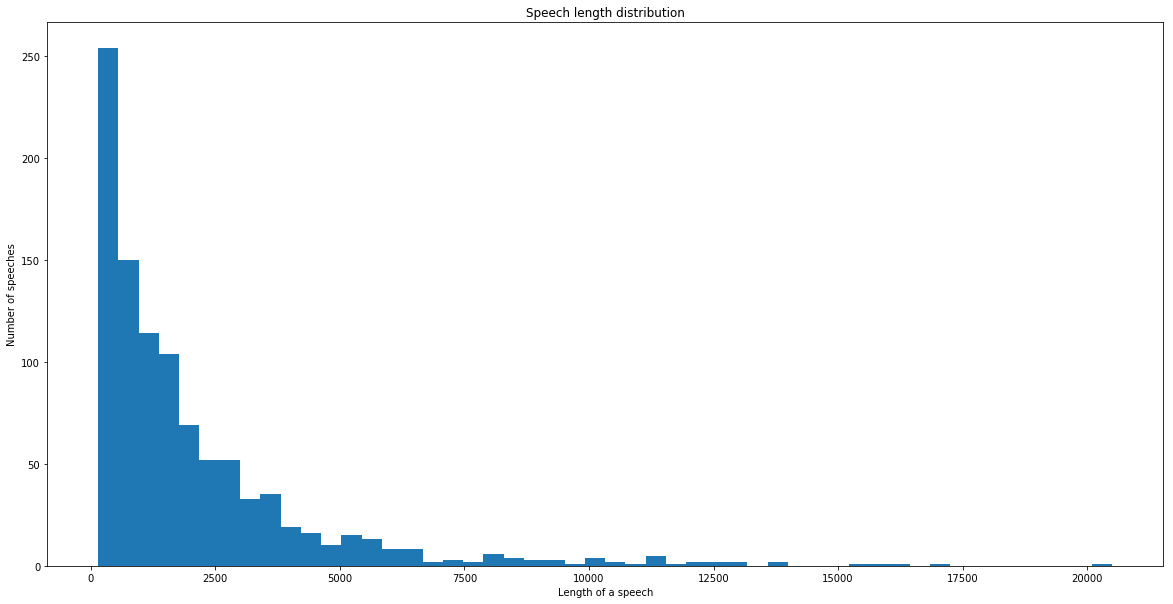

In [28]:
reload(explore_data)
explore_data.plot_sample_length_distribution(train)

### Most popular unigrams (training only)

In [32]:
train_sample = random.sample(train, int(len(train)*0.2))
len(train_sample)

199

['the', 'of', 'to', 'and', 'in', 'that', 'is', 'for', 'this', 'we', 'it', 'on', 'have', 'be', 'are', 'not', 'as', 'with', 'will', 'by', 'has', 'mr', 'would', 'was', 'from', 'they', 'our', 'which', 'an', 'my', 'at', 'their', 'but', 'or', 'his', 'amendment', 'he', 'who', 'bill', 'budget', 'more', 'been', 'president', 'all', 'committee', 'there', 'people', 'time', 'do', 'if']


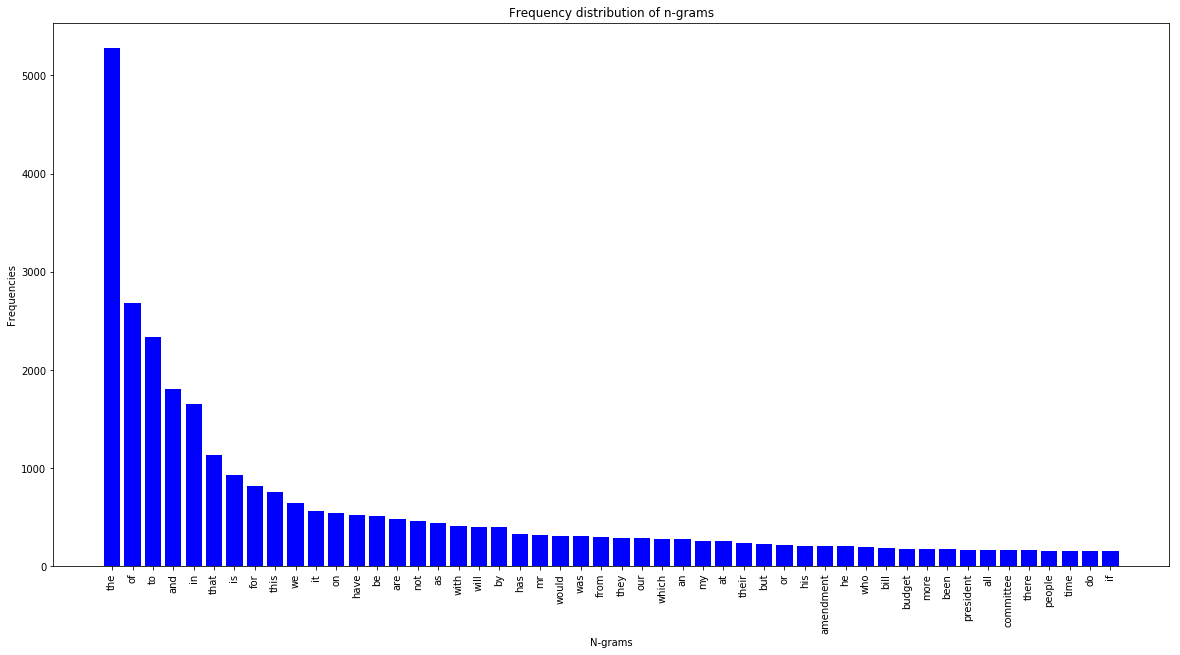

In [33]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(1,1))

### Most popular bigrams (training only)

['of the', 'in the', 'to the', 'it is', 'on the', 'that the', 'for the', 'by the', 'and the', 'of this', 'with the', 'to be', 'mr speaker', 'we are', 'will be', 'we have', 'at the', 'is the', 'mr president', 'that we', 'the gentleman', 'from the', 'the committee', 'the bill', 'of our', 'have been', 'do not', 'this is', 'has been', 'would be', 'this bill', 'there is', 'the united', 'in this', 'the budget', 'the american', 'new york', 'is not', 'the first', 'as the', 'my colleagues', 'united states', 'the federal', 'mr chairman', 'want to', 'this amendment', 'the house', 'that is', 'one of', 'the senate']


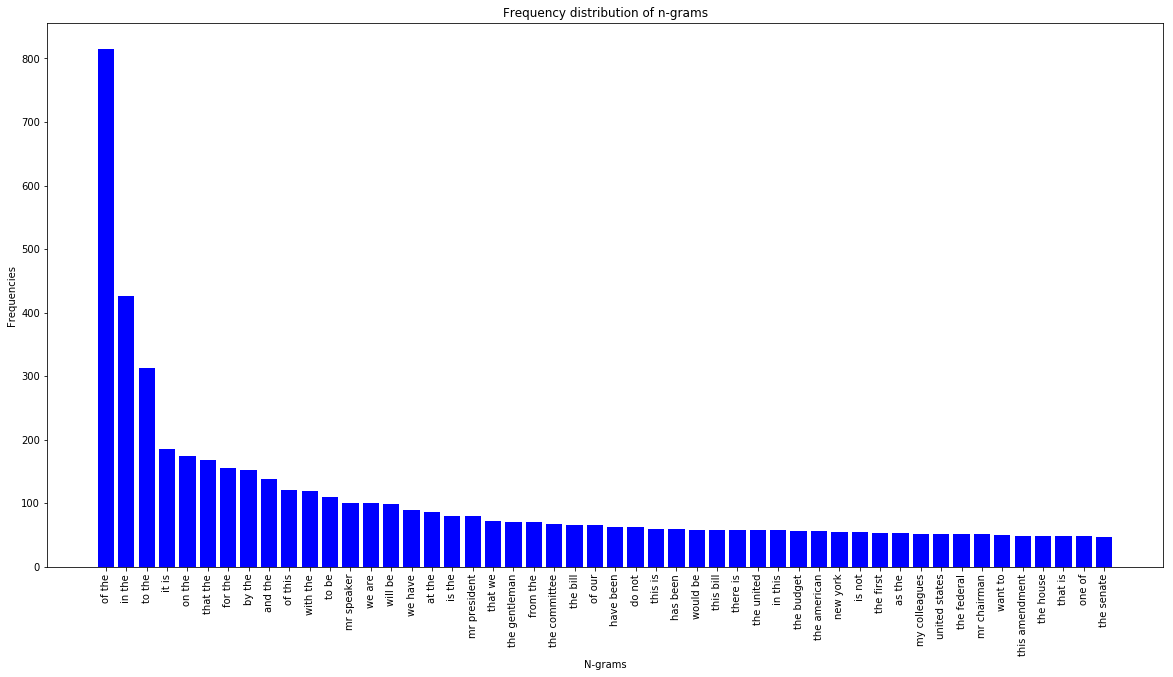

In [34]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(2,2))

### Most popular trigrams (training only)

['the united states', 'the gentleman from', 'would like to', 'one of the', 'the federal government', 'the fact that', 'chairman of the', 'the department of', 'members of the', 'member of the', 'in order to', 'the people of', 'part of the', 'out of the', 'my colleagues to', 'in new york', 'the soviet union', 'the committee on', 'of the senate', 'of the committee', 'of the bill', 'are going to', 'the american people', 'thank the gentleman', 'of the american', 'we do not', 'this is the', 'percent of the', 'of the united', 'of the house', 'new york city', 'the state of', 'the senator from', 'that we are', 'in support of', 'employment and training', 'this amendment is', 'that it is', 'some of the', 'rise in support', 'of the most', 'mr chairman rise', 'is going to', 'going to be', 'there is no', 'of the budget', 'fiscal year 1983', 'as well as', 'we have to', 'we are going']


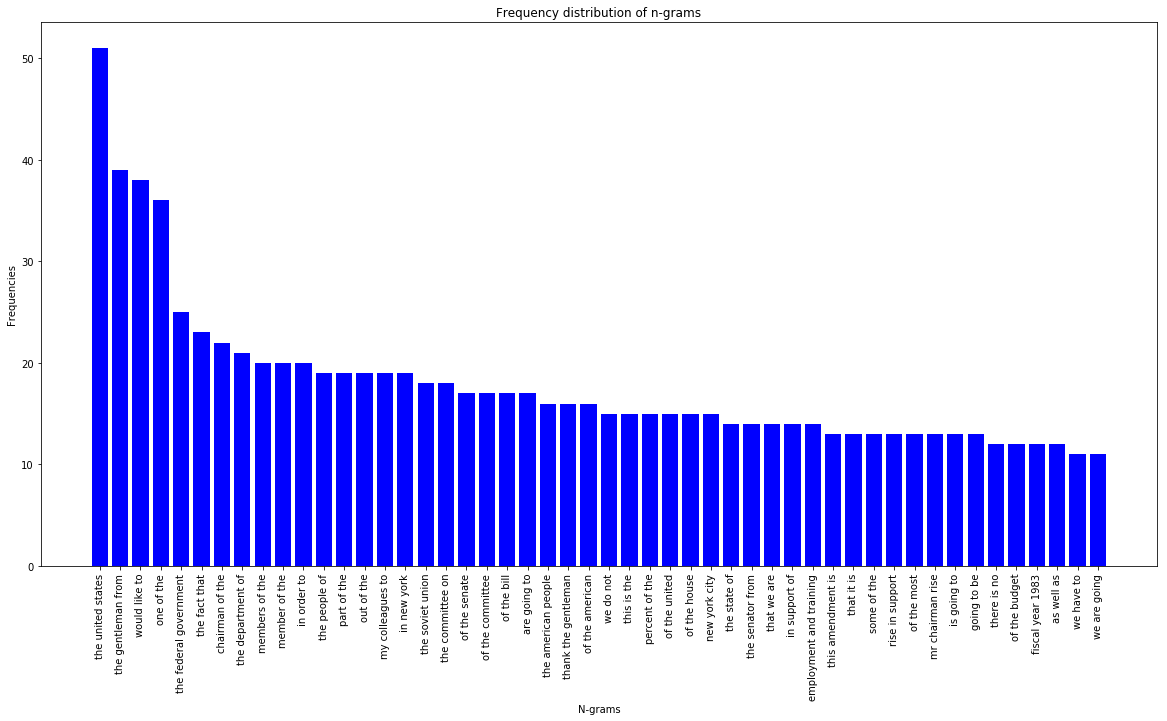

In [35]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(3,3))

In [29]:
congress = set([str(i) for i in range(97,115)])

In [30]:
len(train)

1002

In [31]:
descr['1110063404']

{'Age': '70.0',
 'Age_lt_med': '0.0',
 'Chamber': 'S',
 'Congress': '111',
 'Ethnicity': 'W',
 'Female': '0.0',
 'Full Name': 'ALEXANDER, LAMAR',
 'NonWhite': '0.0',
 'Party': 'R',
 'State': 'TN',
 'char_count': '1356',
 'check': 1,
 'date': '20090930',
 'match': 'exact',
 'speaker': 'Mr. ALEXANDER',
 'speakerid': '111118281.0',
 'word_count': '244'}

In [28]:
reload(explore_data)
explore_data.ngrams_by_category(train, train_ids, descr, congress, 'Congress', p=0.3, top_n=5)


For Congress 97 top 5 (3, 3) ngrams are:
the united states
would like to
of the united
the soviet union
the senator from
--------------------


## N-gram model

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [32]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Minimum corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

# Maximum proportion of corpus containing a word above which a token will be discarded.
# Helps eliminate stop words
MAX_DOCUMENT_FREQUENCY = 0.7

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Output number of top/bottom scoring ngrams
TOP_N = 5

vec_params = {
    'ngram_range': NGRAM_RANGE,
    'min_df': MIN_DOCUMENT_FREQUENCY,
    'max_df': MAX_DOCUMENT_FREQUENCY,
    'top_k': TOP_K,
    'top_n': TOP_N
}

In [33]:
reload(preprocess_data)
train_vec, val_vec, test_vec = preprocess_data.ngram_vectorize(train, train_target, val, test, **vec_params)

/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Total vocabulary size: 12670
Number of stop words 161908

Top 5 ngrams by differentiating score:
mr president 	 82.1
senator 	 51.5
president 	 44.7
the senator 	 40.5
senator from 	 35.1

Bottom 5 ngrams by differentiating score:
senate judiciary 	 0.0
newspaper 	 0.0
to society 	 0.0
this may 	 0.0
myself and 	 0.0


In [34]:
len(train), len(val), len(test)

(1002, 334, 334)

In [35]:
train_vec.shape, val_vec.shape, test_vec.shape

((1002, 12670), (334, 12670), (334, 12670))

### Saving processed files

In [41]:
pwd

'/tf/notebooks/final-project/Classification'

In [61]:
data_path = '/tf/notebooks/final-project/Classification/data'

In [68]:
scipy.sparse.save_npz(os.path.join(data_path, 'train_vec.npz'), train_vec)
scipy.sparse.save_npz(os.path.join(data_path, 'val_vec.npz'), val_vec)
scipy.sparse.save_npz(os.path.join(data_path, 'test_vec.npz'), test_vec)

In [69]:
train_vec = scipy.sparse.load_npz(os.path.join(data_path, 'train_vec.npz'))
val_vec = scipy.sparse.load_npz(os.path.join(data_path, 'val_vec.npz'))
test_vec = scipy.sparse.load_npz(os.path.join(data_path, 'test_vec.npz'))

In [36]:
train_vec.shape, val_vec.shape, test_vec.shape

((1002, 12670), (334, 12670), (334, 12670))

In [72]:
with open(os.path.join(data_path, 'train_list'), 'wb') as fp:
    pickle.dump(train, fp)
with open(os.path.join(data_path, 'train_ids'), 'wb') as fp:
    pickle.dump(train_ids, fp)
with open(os.path.join(data_path, 'train_target'), 'wb') as fp:
    pickle.dump(train_target, fp)
with open(os.path.join(data_path, 'val_list'), 'wb') as fp:
    pickle.dump(val, fp)
with open(os.path.join(data_path, 'val_ids'), 'wb') as fp:
    pickle.dump(val_ids, fp)
with open(os.path.join(data_path, 'val_target'), 'wb') as fp:
    pickle.dump(val_target, fp)
with open(os.path.join(data_path, 'test_list'), 'wb') as fp:
    pickle.dump(test, fp)
with open(os.path.join(data_path, 'test_ids'), 'wb') as fp:
    pickle.dump(test_ids, fp)
with open(os.path.join(data_path, 'test_target'), 'wb') as fp:
    pickle.dump(test_target, fp)

In [73]:
sum(train_target), sum(val_target), sum(test_target)

(498, 166, 166)

In [74]:
with open(os.path.join(data_path, 'train_list'), 'rb') as fp:
    train = pickle.load(fp)
with open(os.path.join(data_path, 'train_ids'), 'rb') as fp:
    train_ids = pickle.load(fp)
with open(os.path.join(data_path, 'train_target'), 'rb') as fp:
    train_target = pickle.load(fp)
with open(os.path.join(data_path, 'val_list'), 'rb') as fp:
    val = pickle.load(fp)
with open(os.path.join(data_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(data_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)
with open(os.path.join(data_path, 'test_list'), 'rb') as fp:
    test = pickle.load(fp)
with open(os.path.join(data_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(data_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)

In [75]:
sum(train_target), sum(val_target), sum(test_target)

(498, 166, 166)

### Model: Multi-Layer Perceptron (Vanilla NN)

In [40]:
logs_base_dir = "/tf/notebooks/final-project/logs"

In [38]:
model_params = {
    'learning_rate': 1e-3,
    'epochs': 1000,
    'batch_size': 128,
    'layers': 2,
    'units': 64,
    'dropout_rate': 0.2
}

In [41]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_ngram_model(((train_vec, train_target), (val_vec, val_target)), logs_base_dir, **model_params)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Train on 1002 samples, validate on 334 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
 - 0s - loss: 0.6907 - acc: 0.5649 - val_loss: 0.6853 - val_acc: 0.6946
Epoch 2/1000
 - 0s - loss: 0.6633 - acc: 0.8593 - val_loss: 0.6703 - val_acc: 0.7066
Epoch 3/1000
 - 0s - loss: 0.6253 - acc: 0.8623 - val_loss: 0.6547 - val_acc: 0.7066
Epoch 4/1000
 - 0s - loss: 0.5835 - acc: 0.8892 - val_loss: 0.6394 - val_acc: 0.7066
Epoch 5/1000
 - 0s - loss: 0.5400 - acc: 0.9102 - val_loss: 0.6243 - val_acc: 0.7156
Epoch 6/1000
 - 0s - loss: 0.4967 - acc: 0.9401 - val_loss: 0.6100 - val_acc: 0.7156
Epoch 7/1000
 - 0s - loss: 0.4507 - acc: 0.9521 - val_loss: 0.5971 - val_acc: 0.7066
Epoch 8/1000
 - 0s - loss: 0.4083 - acc: 0.9581 - val_loss: 0.5856 - val_acc: 0.7066
Epoch 9/1000
 - 0s - loss: 0.3676 - ac

## Model evaluation

In [42]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

243

Confusion matrix, without normalization
[[121  46]
 [ 45 122]]


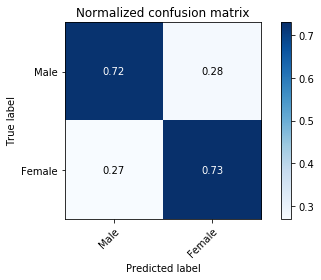

In [43]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

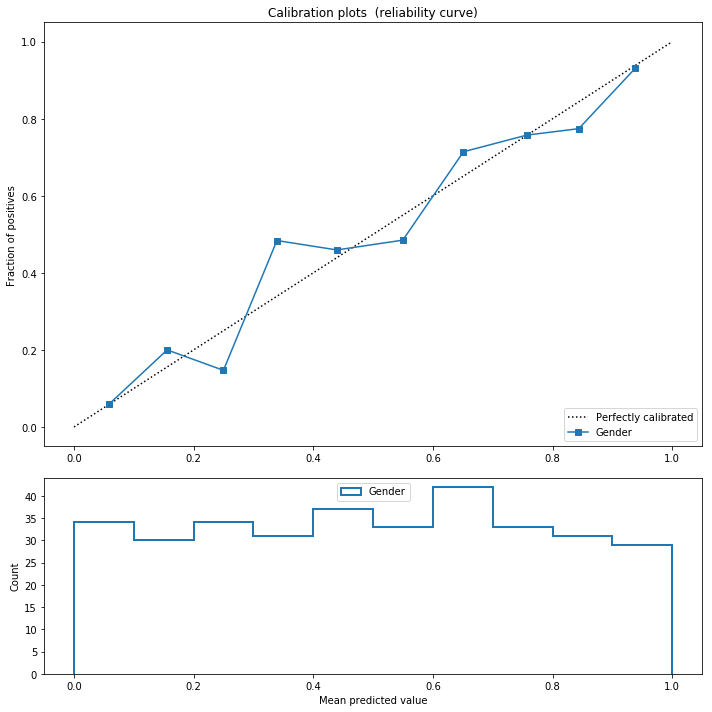

In [44]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Gender')

In [45]:
val_random = np.random.choice(a=[0,1], size=len(val_target), p = [0.7,0.3])
val_random.sum()/val_random.shape[0]

0.2874251497005988

In [49]:
val_sample, val_ids_sample, val_pred_probs_sample = [], [], []
for i in range(len(val_ids)):
    if val_random[i] == 1:
        val_sample.append(val[i])
        val_ids_sample.append(val_ids[i])
        val_pred_probs_sample.append(val_pred_probs[i])
len(val_sample), len(val_ids_sample), len(val_pred_probs_sample)

(96, 96, 96)

In [54]:
reload(explore_data)
explore_data.check_bin_probs_distr(val_pred_probs_sample, val_ids_sample, descr)

Finished building main df
Finished bin 0.4
Finished bin 0.6
Finished bin 1.0


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.31,0.00,1.07,0.83,0.66,0.98
0.6,0.83,0.00,0.95,0.90,0.98,1.06
1.0,1.70,2.46,0.97,1.21,1.30,0.99


In [59]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs)


Top 10 ngrams by differentiating score:
ask unanimous consent that 	 17.1
unanimous consent that 	 17.1
ask unanimous consent 	 14.0
the senator from 	 11.9
in support of 	 9.4
subcommittee on civil service 	 7.9
on civil service 	 7.9
and to make 	 7.9
consent that the 	 7.6
unanimous consent that the 	 7.6


,0.4,0.6,1.0
and to make,0.0,4.0,0.0
ask unanimous consent,25.0,3.0,0.0
ask unanimous consent that,22.0,0.0,0.0
consent that the,9.0,0.0,0.0
in support of,2.0,6.0,25.0
on civil service,0.0,4.0,0.0
subcommittee on civil service,0.0,4.0,0.0
the senator from,37.0,0.0,0.0
unanimous consent that,22.0,0.0,0.0
unanimous consent that the,9.0,0.0,0.0


In [58]:
reload(explore_data)
explore_data.ngrams_by_bin(val_sample, val_pred_probs_sample)


In 0.4 bin top 10 ngrams:

the united states
the gentleman from
of the united states
of the united
the department of
unanimous consent that
this is the
of the island
fairfax symphony orchestra
ask unanimous consent that
--------------------

In 0.6 bin top 10 ngrams:

the federal government
the united states
the secretary of
the estate tax
the washington post
the dairy support program
the dairy support
for the federal
dairy support program
aware of the
--------------------

In 1.0 bin top 10 ngrams:

the united states
percent of the
would like to
out of the
we should not
the obey substitute
the number of
the federal government
thank the gentleman
one of the
--------------------


In [60]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr)


True positive (Predicted prob: 0.91):

char_count 1473
speaker Mrs. ROUKEMA
Chamber H
Party R
match exact
Ethnicity W
Full Name ROUKEMA, MARGE
Age 53.0
Age_lt_med 0.0
date 19820921
State NJ
word_count 226
NonWhite 0.0
check 1
Female 1.0
Congress 97
speakerid 97113260.0

 Mr. Chairman. today I reluctantly rise in opposition to this legislation. Reluctantly because this bill contains appropriations for a number of programs which are important to my own State. as well as appropriations for transportation programs important to our country as a whole. It is unfortunate that the committee has chosen to jeopardize the funding of these vital programs by neglecting to report out a bill that represents true spending requirements. First. due to recently passed increased aviation taxes. supplemental amounts totaling $323 million will be required for FAA. facilities and equipment. and research engineering and development. Second. the committee bill does not include $61 million that will be require